In [1]:
import cv2
import matplotlib.pyplot as plt

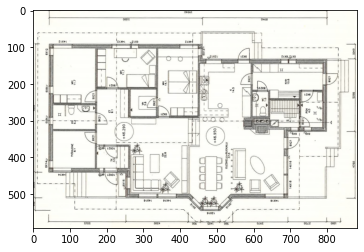

In [4]:
original = cv2.cvtColor(cv2.imread('original.png'), cv2.COLOR_BGR2RGB)
plt.imshow(original)

# from segmentation import predict
# rooms_pred, icons_pred, heatmaps = predict(original)


In [2]:
import numpy as np
import torch
from torch.nn import functional as F

from floortrans.models import get_model
from floortrans.loaders import RotateNTurns
from floortrans.post_prosessing import split_prediction

room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]
n_classes = 44
model = get_model('hg_furukawa_original', 51)
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()

def predict(image):
    rot = RotateNTurns()    

    image = torch.from_numpy(np.moveaxis(image, 2, 0).reshape(1, 3, image.shape[0], image.shape[1]))
    image = ((image / 255) * 2 - 1).float()

    with torch.no_grad():
        height = image.shape[2]
        width = image.shape[3]
        
        rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
        pred_count = len(rotations)
        prediction = torch.zeros([pred_count, n_classes, height, width])
        for i, r in enumerate(rotations):
            forward, back = r
            # We rotate first the image
            rot_image = rot(image, 'tensor', forward)
            pred = model(rot_image)
            # We rotate prediction back
            pred = rot(pred, 'tensor', back)
            # We fix heatmaps
            pred = rot(pred, 'points', back)
            # We make sure the size is correct
            pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
            # We add the prediction to output
            prediction[i] = pred[0]

        prediction = torch.mean(prediction, 0, True)

    rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
    rooms_pred = np.argmax(rooms_pred, axis=0)

    icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
    icons_pred = np.argmax(icons_pred, axis=0)

    heatmaps, _, _ = split_prediction(prediction, (height, width), [21, 12, 11])

    return rooms_pred, icons_pred, heatmaps

/mnt/c/Users/joaodavid/Desktop/practical/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
rooms_pred, icons_pred, heatmaps = predict(original)

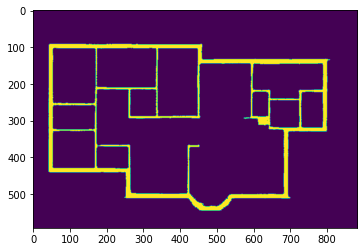

In [9]:
import numpy as np
from utils.image_manipulation import as_image

walls_closed = as_image(rooms_pred == 2)
plt.imshow(walls_closed)

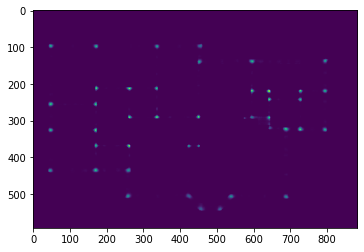

In [17]:
wall_pixels = walls_closed.copy()
wall_heatmaps = heatmaps[:13]
junctions = wall_heatmaps.sum(axis=0) * (wall_pixels//255)
# junctions = np.where(junctions > 0.2, 1, 0)

plt.imshow(junctions)